In [19]:
# import os

# # Set the Kaggle API credentials as environment variables
# os.environ['KAGGLE_USERNAME'] = 'ashokneupane'
# os.environ['KAGGLE_KEY'] = ''

# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# !unzip /content/chest-xray-pneumonia.zip -d /content

In [20]:
import os
import cv2
import numpy as np
import keras
import tensorflow as tf
import tensorboard
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint
from IPython.display import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Flatten

In [39]:
TRAIN_PATH = '/content/chest_xray/train'
VAL_PATH = '/content/chest_xray/val'
TEST_PATH = '/content/chest_xray/test'
IMG_WIDTH, IMG_HEIGHT, CHANNEL = 150, 150, 3
CATEGORIES = ['NORMAL','PNEUMONIA']
BATCH_SIZE = 32
EPOCHS = 2


In [22]:
# def load_images(dir):
#   images = []
#   labels = []
#   for category in CATEGORIES:
#     for filename in os.listdir(os.path.join(dir, category)):
#       img = cv2.imread(os.path.join(dir, category,filename))
#       img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT))
#       img = img.astype('float32')/255.0
#       images.append(img)
#       if category == 'NORMAL':
#         labels.append(int(0))
#       else:
#         labels.append(int(1))
#   return np.array(images),np.array(labels)

In [23]:
# train_datagen = ImageDataGenerator(rotation_range=30, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# train_img, train_labels = load_images(TRAIN_PATH)
# # train_datagen.fit(train_img)
# # train_img = train_datagen.flow(train_img, batch_size=BATCH_SIZE)
# val_img, val_labels = load_images(VAL_PATH)
# test_img, test_labels = load_images(TEST_PATH)

In [42]:
train_data_gen = ImageDataGenerator(rotation_range=30, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train = train_data_gen.flow_from_directory(TRAIN_PATH,
                                           target_size=(IMG_WIDTH,IMG_HEIGHT),
                                           batch_size=BATCH_SIZE,
                                           class_mode='binary')
val = ImageDataGenerator().flow_from_directory(VAL_PATH,
                                           target_size=(IMG_WIDTH,IMG_HEIGHT),
                                           batch_size=BATCH_SIZE,
                                           class_mode='binary')
test = ImageDataGenerator().flow_from_directory(TRAIN_PATH,
                                           target_size=(IMG_WIDTH,IMG_HEIGHT),
                                           batch_size=BATCH_SIZE,
                                           class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [40]:
def get_model():
  base_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL))
  for layer in base_model.layers:
    layer.trainable = False
  model = Sequential()
  model.add(base_model)
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [26]:
log_dir = 'log/'
tensorboard_callback = TensorBoard(log_dir=log_dir)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('checkpoint.h5', save_weights_only=True, save_best_only=True)

In [43]:
model = get_model()
history = model.fit_generator(train, epochs=EPOCHS, validation_data=val, verbose=1, callbacks=[early_stop, tensorboard_callback, checkpoint])
model.save('pneumonia.h5')

Epoch 1/2


ValueError: ignored

In [29]:
def plot_history(history, title='training_history'):
    """Plot the training and validation loss and Plot the training and validation accuracy

    Args:
        history (keras model history): its the values returned by model.fit() method
        title (str): name of the model
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

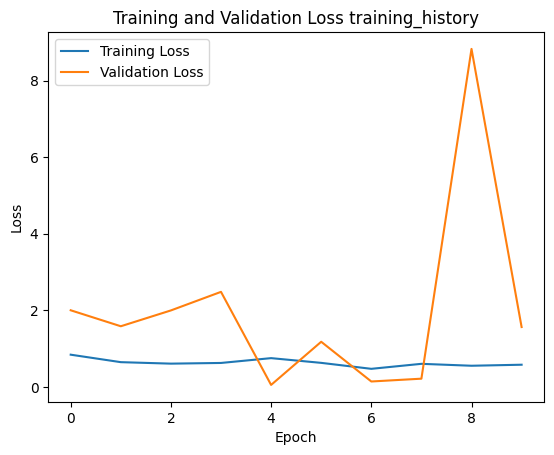

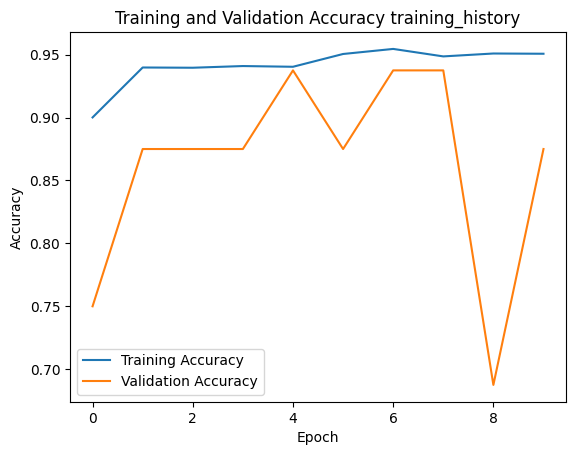

In [30]:
plot_history(history)

In [53]:
from keras.saving.legacy.save import load_model
def predict_image(img):
  # display(Image(data=cv2.imencode('.jpg', img)[1].tobytes()))

  img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
  img = np.array(img) / 255.0
  img = np.expand_dims(img, axis=0)
  model = load_model('/content/pneumonia.h5')
  prediction_transfer_learning = model.predict(img)
  print(prediction_transfer_learning)
  predicted = 'pneumonia' if prediction_transfer_learning[0][0] >0.5 else 'normal'
  print('Predicted : ', predicted)

predict_image(cv2.imread('/content/chest_xray/test/PNEUMONIA/person1627_virus_2819.jpeg'))
predict_image(cv2.imread('/content/chest_xray/test/PNEUMONIA/person1627_virus_2819.jpeg'))
predict_image(cv2.imread('/content/chest_xray/train/PNEUMONIA/person1007_virus_1690.jpeg'))
predict_image(cv2.imread('/content/chest_xray/test/NORMAL/IM-0007-0001.jpeg'))
predict_image(cv2.imread('/content/chest_xray/test/NORMAL/IM-0036-0001.jpeg'))
predict_image(cv2.imread('/content/chest_xray/train/NORMAL/IM-0166-0001.jpeg'))

1/1 [==============================] - 0s 164ms/step
[[0.99861825]]
Predicted :  pneumonia
1/1 [==============================] - 0s 159ms/step
[[0.99861825]]
Predicted :  pneumonia
1/1 [==============================] - 0s 161ms/step
[[0.9968925]]
Predicted :  pneumonia
1/1 [==============================] - 0s 152ms/step
[[0.99384403]]
Predicted :  pneumonia
1/1 [==============================] - 0s 161ms/step
[[0.9986449]]
Predicted :  pneumonia
1/1 [==============================] - 0s 170ms/step
[[0.99688524]]
Predicted :  pneumonia
